In [1]:
import os
import ast
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from os import PathLike


In [3]:
plt.rcParams['axes.titlesize'] = 10  # Adjust the size of the title
plt.rcParams['axes.labelsize'] = 8  # Adjust the size of the axis labels
plt.rcParams['xtick.labelsize'] = 6  # Adjust the size of the x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Adjust the size of the y-axis tick labels
plt.rcParams['font.size'] = 8  # General font size for all text elements
plt.rcParams['legend.fontsize'] = 6  # Font size for legend text

# Set global line width for axes and ticks
plt.rcParams['axes.linewidth'] = 0.2  # Adjust the thickness of the axes frame lines
plt.rcParams['xtick.major.width'] = 0.1  # Adjust the thickness of the major tick lines on the x-axis
plt.rcParams['ytick.major.width'] = 0.1  # Adjust the thickness of the major tick lines on the y-axis
plt.rcParams['xtick.minor.width'] = 0.05  # Adjust the thickness of the minor tick lines on the x-axis
plt.rcParams['ytick.minor.width'] = 0.05  # Adjust the thickness of the minor tick lines on the y-axis

In [4]:
def smooth_data(data, window_size=5):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_model_metrics(
        metrics_file: PathLike,
        title: str | None=None,
        type: str='valid', 
        step: bool=False, 
        image_size_cm: list[int]=[14,7], 
        window_size: int=5
        ):

    """
    Plot the training and validation metrics of a run.

    Parameters:

        run (str): Run name.
        type (str): Type of metrics ('train', 'valid'). Default is 'valid'.
        step (bool): for type 'train', plot step instead of epoch. Default is False.
        image_size_cm (list): Size of the output image in cm.
        window_size (int): Size of the smoothing window. Default is 5.

    """
    metrics = pd.read_csv(metrics_file)

    if type == 'valid':
        loss = 'val_loss'
        acc = 'val_acc'
        label = ['Validation Loss', 'Validation Accuracy']
    elif type == 'train':
        label = ['Training Loss', 'Training Accuracy']
        if step:
            loss = 'train_loss_step'
            acc = 'train_acc_step'
        else:
            loss = 'train_loss_epoch'
            acc = 'train_acc_epoch'

    validation_data = metrics[~metrics[loss].isnull()]

    # Smooth the data
    smoothed_val_loss = smooth_data(validation_data[loss], window_size=window_size)
    smoothed_val_acc = smooth_data(validation_data[acc], window_size=window_size)

    # Adjust the epoch range to match the length of the smoothed data
    epochs = validation_data['epoch'][len(validation_data['epoch']) - len(smoothed_val_loss):]

    fig, ax1 = plt.subplots(figsize=(image_size_cm[0]/2.54, image_size_cm[1]/2.54))

    if title:
        plt.title(title)

    # Plot unsmoothed valid_loss on the primary y-axis
    ax1.plot(validation_data['epoch'], validation_data[loss], color='#A6CEE3', label='', linewidth=1, alpha=0.5)
    # Plot smoothed valid_loss on the primary y-axis
    ax1.plot(epochs, smoothed_val_loss, color='#1F78B4', label=label[0], linewidth=0.5)


    # Adjust y-axis limits for loss
    loss_min = float(validation_data[loss].min())
    loss_max = float(validation_data[loss].max())
    ax1.set_ylim(loss_min * 0.87, loss_max * 1)

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel(label[0])
    ax1.tick_params(axis='y')

    # Create a secondary y-axis to plot valid_acc
    ax2 = ax1.twinx()
    # Plot unsmoothed valid_acc on the secondary y-axis
    ax2.plot(validation_data['epoch'], validation_data[acc], color='#FB9A99', label='', linewidth=1, alpha=0.5)
    # Plot smoothed valid_acc on the secondary y-axis
    ax2.plot(epochs, smoothed_val_acc, color='#E31A1C', label=label[0], linewidth=0.5)
    ax2.set_ylabel(label[1])
    ax2.tick_params(axis='y')

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    fig.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower center', bbox_to_anchor=(0.5, 0.2), ncol=2)

    fig.tight_layout()
    
    return fig

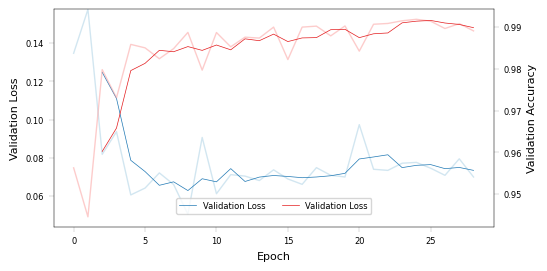

In [ ]:
# Plotting validation metrics of efficientnet_b0_v3_from_scratch

metrics_file = Path('/cfs/earth/scratch/kraftjul/BA/output/runs/efficientnet_b0_v3_from_scratch/metrics.csv')
best_model_loss = plot_model_metrics(
                        metrics_file=metrics_file,
                        title=None,
                        type='valid', 
                        step=False, 
                        image_size_cm=[14,7], 
                        window_size=3
                        )

In [34]:
# evaluating prediction performance

predictions_path = Path('/cfs/earth/scratch/kraftjul/BA/output/runs/efficient_v1/predictions.csv')
dataset_path = Path('/cfs/earth/scratch/kraftjul/BA/output/runs/efficient_v1/dataset.csv')

dataset = pd.read_csv(dataset_path)
predictions = pd.read_csv(predictions_path).drop(columns=['class_id'])

# Merge the predictions with the dataset by index

df = pd.merge(dataset, predictions, left_index=True, right_index=True)

def safe_eval(x):
    if isinstance(x, str):
        return ast.literal_eval(x)
    return x

for col in ['bbox', 'probs']:
    df[col] = df[col].apply(safe_eval)

df['correct'] = df['class_id'] == df['pred_id']

df['probs_max'] = [
    prob_list[pred] 
    for prob_list, pred in zip(df['probs'], df['pred_id'])
]

In [ ]:
class LoadRun():
    def __init__(
            self,
            log_path: str | PathLike
            ):
        
        self.log_path = Path(log_path)
        
        self.info = self.get_experiment_info()      
        self.cross_val = self.info['cross_val']['apply']

    def get_experiment_info(self):
        with open(self.log_path / 'experiment_info.yaml') as f:
            return yaml.safe_load(f)
        
    def get_predictions(
            self,
            fold: int | None=None,
            ):
        
        if self.cross_val and fold:
            predictions_path = self.log_path / f'fold_{fold}' / 'predictions.csv'
        elif: 

        



In [6]:
run = LoadRun(
        log_path='/cfs/earth/scratch/kraftjul/BA/output/runs/efficient_v1'
        )

In [8]:
run.cross_val

False